# MultiModal RAG Styling Assistant Demonstration - Utilizing GPT4o And OpenCLIP Multimodal Embeddings

#### This notebook provides a demonstration of the use of multimodal RAG as a fashion stylist assistant.  GPT4o, OpenCLIP multimodal embeddings, a ChromaDB vector database and the Fashionpedia dataset available through Hugging Face are used in this example.  Fashionpedia is an ideal database for use in a multimodal RAG shopping application demo notebook.  The OpenAI GPT4o model has vision capabilities which enable multimodal processing.  Images are encoded to base64 to enable the LLM to process them. The LangChain framework is used to link all applications.

#### CLIP training uses a dual encoder architecture with a vision transformer used for the image encoder and an LLM (transformer) used for the text encoder.  The vision and text encoders are jointly trained to predict whether a specific text is likely to accompany an image and the embeddings are projected into a unified embedding space.  CLIP (Contrastive Languge Image Pre-Training) was developed by OpenAI and later open sourced as OpenCLIP and can perform multimodal zero shot classification of images and text.

### Import Dependencies

In [ ]:
!pip install -q chromadb==0.5.5
!pip install -q datasets==2.21.0
!pip install -q langchain==0.2.15
!pip install -q langchain-openai==0.1.23
!pip install -q langchain-community==0.2.15
!pip install -q open_clip_torch==2.26.1
import tensorflow as tf
import os
import chromadb
import base64
import langchain_openai
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from IPython.display import Image, display, Markdown
from datasets import load_dataset
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.llms import OpenAI

In [ ]:
# Utilize GPU if available
# Get the list of available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    # If a GPU is available, use it
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    device = "/GPU:0"
    print("Using GPU")
else:
    # If no GPU is available, use CPU
    device = "/CPU:0"
    print("Using CPU")

Using GPU


### Load Dataset

In [ ]:
# Load fashionpedia dataset available through HuggingFace
dataset = load_dataset("detection-datasets/fashionpedia")

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]

### Display Sample Image

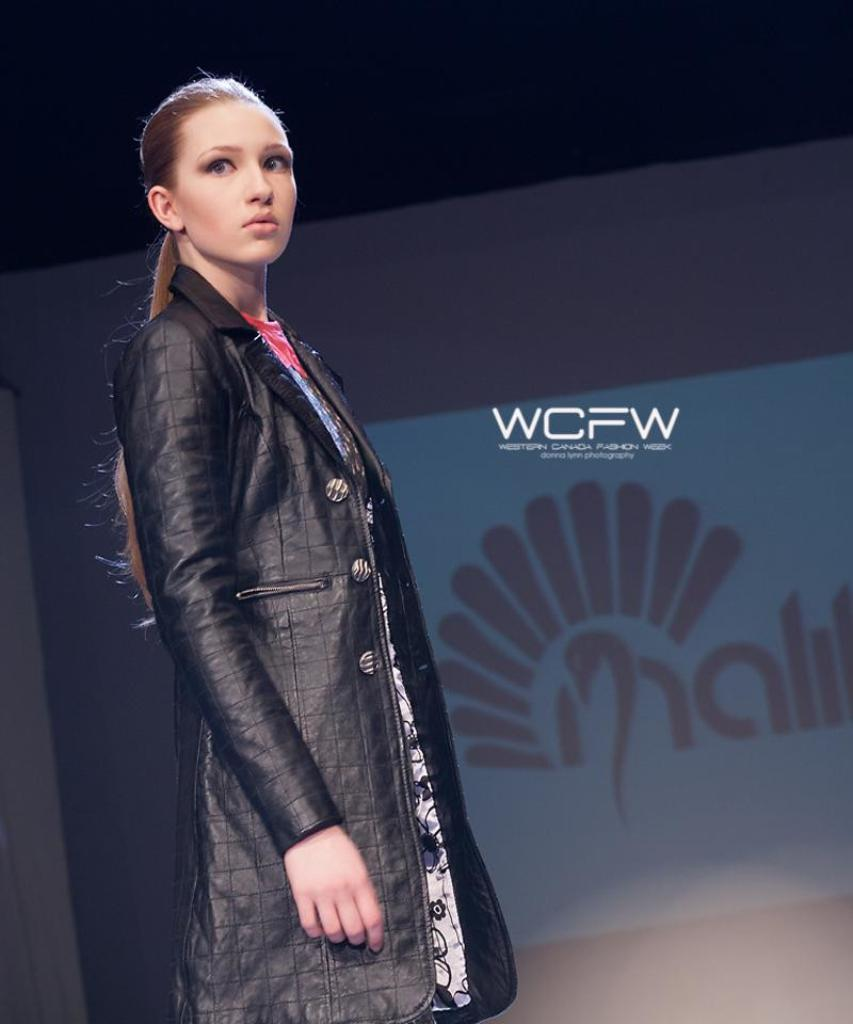

In [ ]:
# Display example dataset image
dataset['train'][4]['image']

### Save First 1000 Images To Google Drive

In [ ]:
# Mount Google drive to save and access parts of the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the folder to save the dataset images images
dataset_folder = '/content/drive/My Drive/multimodal_dataset/fashionpedia'
os.makedirs(dataset_folder, exist_ok=True)

# Function to save images
def save_images(dataset, dataset_folder, num_images=1000):
    for i in range(num_images):
        # Get the image data
        image = dataset['train'][i]['image']

        # Save the image
        image.save(os.path.join(dataset_folder, f'image_{i+1}.png'))

# Save the first 1000 images
save_images(dataset, dataset_folder, num_images=1000)

print(f"Saved the first 1000 images to {dataset_folder}")

Saved the first 1000 images to /content/drive/My Drive/multimodal_dataset/fashionpedia


### Prepare ChromaDB Vector Database

In [ ]:
# Instantiate the ChromaDB CLient
chroma_client = chromadb.PersistentClient(path='/content/drive/My Drive/multimodal_vdb/fashionpedia')
# Instantiate the ChromaDB Image Loader
image_loader = ImageLoader()
# Instantiate CLIP embeddings
CLIP = OpenCLIPEmbeddingFunction()

# Create the image vector database
image_vdb = chroma_client.get_or_create_collection(name="image", embedding_function = CLIP, data_loader = image_loader)

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_loc

### Load Images

In [ ]:
# Initialize lists for ids and uris (uniform resource identifiers, which in this case is just the path to the image)
ids = []
uris = []

# Iterate over each file in the dataset folder
for i, filename in enumerate(sorted(os.listdir(dataset_folder))):
    if filename.endswith('.png'):
        file_path = os.path.join(dataset_folder, filename)

        # Append id and uri to respective lists
        ids.append(str(i))
        uris.append(file_path)

# Assuming multimodal_db is already defined and available
image_vdb.add(
    ids=ids,
    uris=uris
)

print("Images added to the database.")


Images added to the database.


In [ ]:
# Validate the VectorDB with .count()
image_vdb.count()

1000

### Define Vector Database Query Functions

ID: 841
Distance: 1.449376106262207
Path: /content/drive/My Drive/multimodal_dataset/fashionpedia/image_856.png


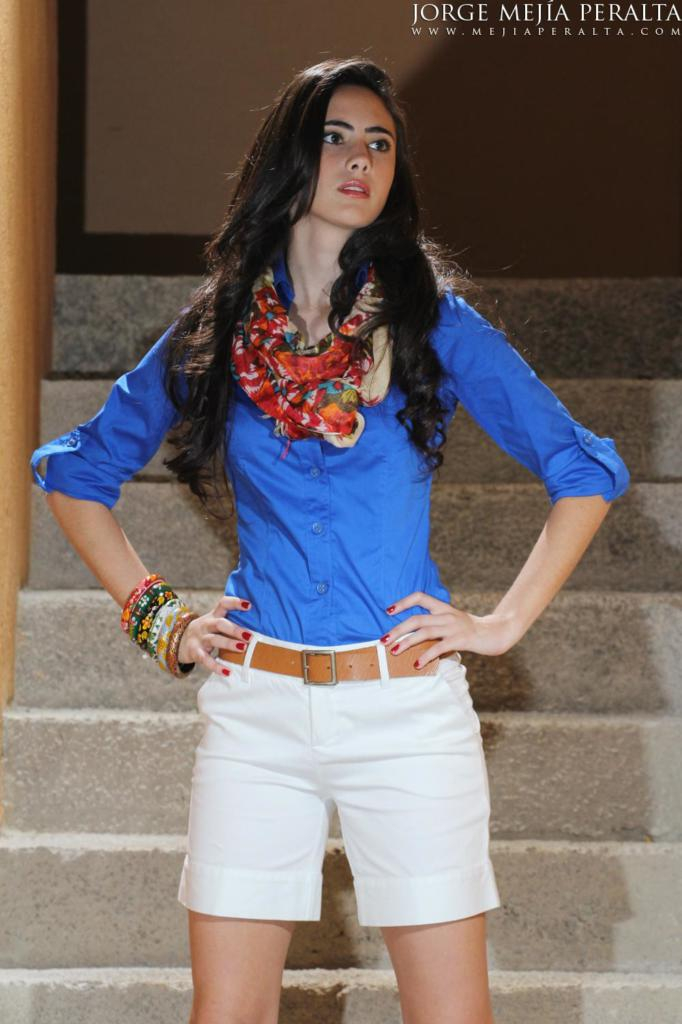



ID: 414
Distance: 1.460972547531128
Path: /content/drive/My Drive/multimodal_dataset/fashionpedia/image_471.png


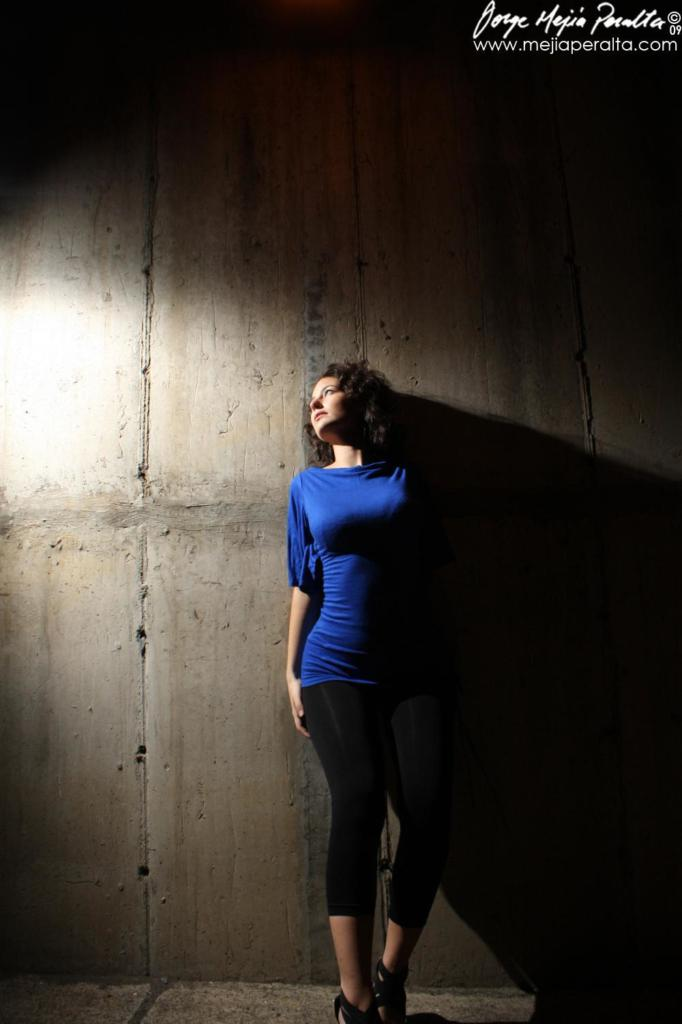



ID: 297
Distance: 1.4763634204864502
Path: /content/drive/My Drive/multimodal_dataset/fashionpedia/image_366.png


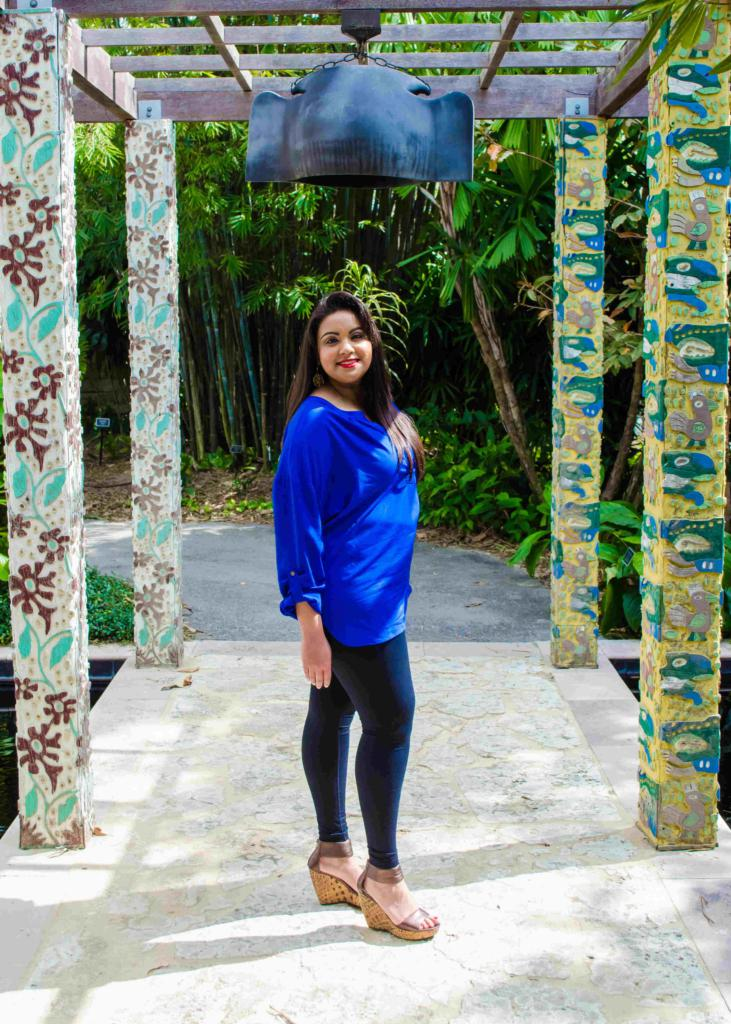



ID: 570
Distance: 1.4808926582336426
Path: /content/drive/My Drive/multimodal_dataset/fashionpedia/image_611.png


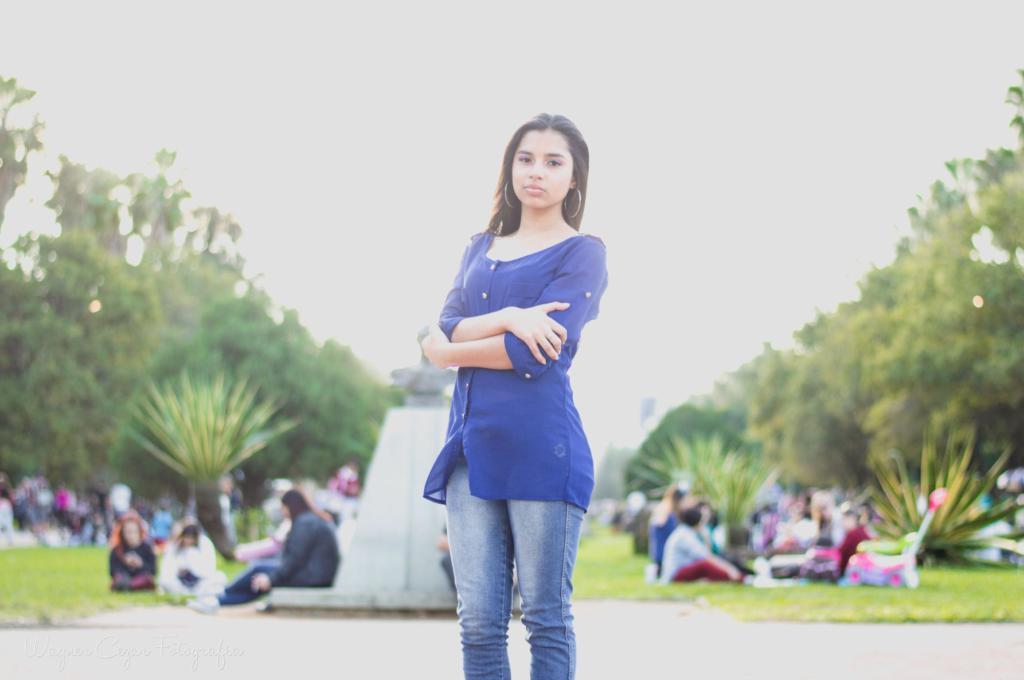



ID: 787
Distance: 1.4820361137390137
Path: /content/drive/My Drive/multimodal_dataset/fashionpedia/image_807.png


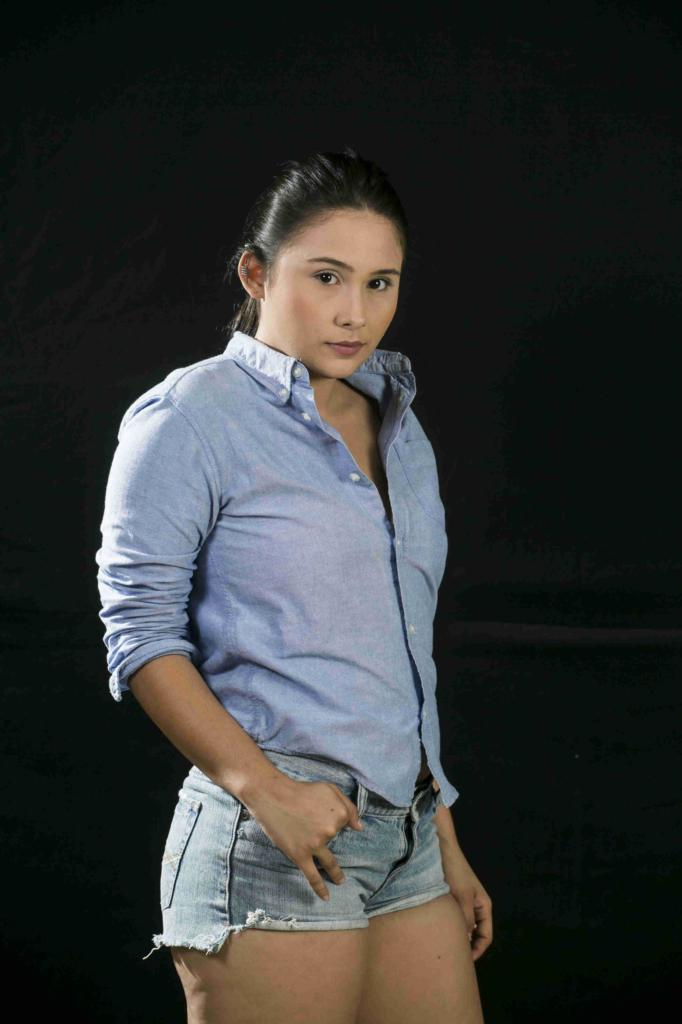

In [ ]:
# Define query_db function
def query_db(query, results=5):
    results = image_vdb.query(
        query_texts=[query],
        n_results=results,
        include=['uris', 'distances'])
    return results

# Define print_results function
def print_results(results):
    for idx, uri in enumerate(results['uris'][0]):
        print(f"ID: {results['ids'][0][idx]}")
        print(f"Distance: {results['distances'][0][idx]}")
        print(f"Path: {uri}")
        display(Image(filename=uri, width=300))
        print("\n")

# Demonstrate functions
query = 'blue shirt'
results = query_db(query)
print_results(results)

In [ ]:
# Read API Key and Password
import os

# Read attached config.txt
with open('/content/config.txt') as f:
    for line in f:
        # Strip any leading/trailing whitespace
        line = line.strip()
        # Skip empty lines or lines without '='
        if not line or '=' not in line:
            continue
        # Split the line on '='
        parts = line.split('=', 1)  # Only split on the first '='
        if len(parts) == 2:  # Check if the split line has exactly two parts
            key, value = parts  # Unpack the key and value
            os.environ[key] = value  # Set the environment variable
        else:
            # Optionally print a warning or handle the unexpected line format
            print(f"Skipping line: {line}, incorrect format")

### Define LangChain Chain, LLM,  and Prompt

In [ ]:
# Instantiate GPT4o
gpt4o = ChatOpenAI(model="gpt-4o", temperature = 0.0)

# Instantiate the Output Parser
parser = StrOutputParser()

# Define the Prompt
image_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful fashion and styling assistant. Answer the user's question  using the given image context with direct references to parts of the images provided."
                    " Maintain a more conversational tone, don't make too many lists. Use markdown formatting for highlights, emphasis, and structure."),
        (
            "user",
            [
                {"type": "text", "text": "What are some ideas for styling {user_query}"},
                {"type": "image_url", "image_url": "data:image/jpeg;base64,{image_data_1}"},
                {"type": "image_url", "image_url": "data:image/jpeg;base64,{image_data_2}"},
            ],
        ),
    ]
)

# Define the LangChain Chain
vision_chain = image_prompt | gpt4o | parser

### Format Query Results for LLM Prompting

In [ ]:
# Define a function whereby a user query and two images are passed to GPT4o
def format_prompt_inputs(data, user_query):
    inputs = {}

    # Add user query to the dictionary
    inputs['user_query'] = user_query

    # Get the first two image paths from the 'uris' list
    image_path_1 = data['uris'][0][0]
    image_path_2 = data['uris'][0][1]

    # Encode the first image
    with open(image_path_1, 'rb') as image_file:
        image_data_1 = image_file.read()
    inputs['image_data_1'] = base64.b64encode(image_data_1).decode('utf-8')

    # Encode the second image
    with open(image_path_2, 'rb') as image_file:
        image_data_2 = image_file.read()
    inputs['image_data_2'] = base64.b64encode(image_data_2).decode('utf-8')

    return inputs

Note:  The function above creates a dictionary along with the initial user query to pass into the chain. The chain accepts a dictionary input corresponding to three pieces of information needed: `{user_query}`, `{image_data_1}`, `{image_data_2}`.

The function output (in the format shown below) is added to the prompt before the combination (function output + prompt) is passed to the LLM (GPT4o).

The format of the function output is:

```python
{
    "user_query": "What are some ideas for styling a specific item"
    "image_data_1": Base64 Encoding of Image 1
    "image_data_2": Base64 Encoding of Image 2
}
```

### Demonstration of Fashion Stylist RAG Application

## Stylist Assistant is ready!

What would you like to style today?


Gray Jacket


---

**Example Picture 1:**

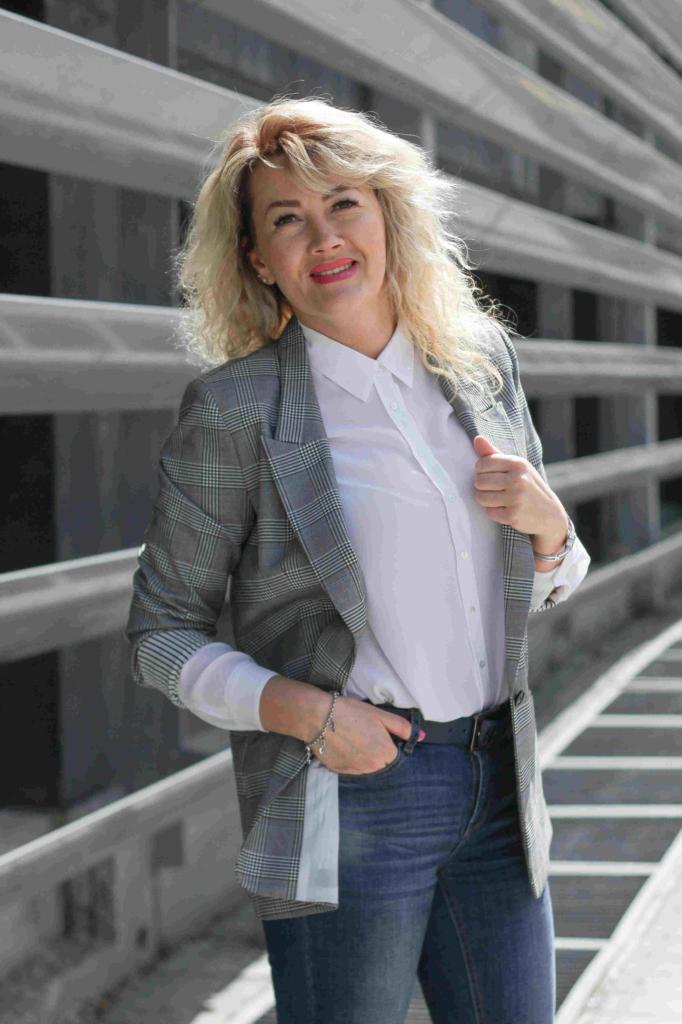

**Example Picture 2:**

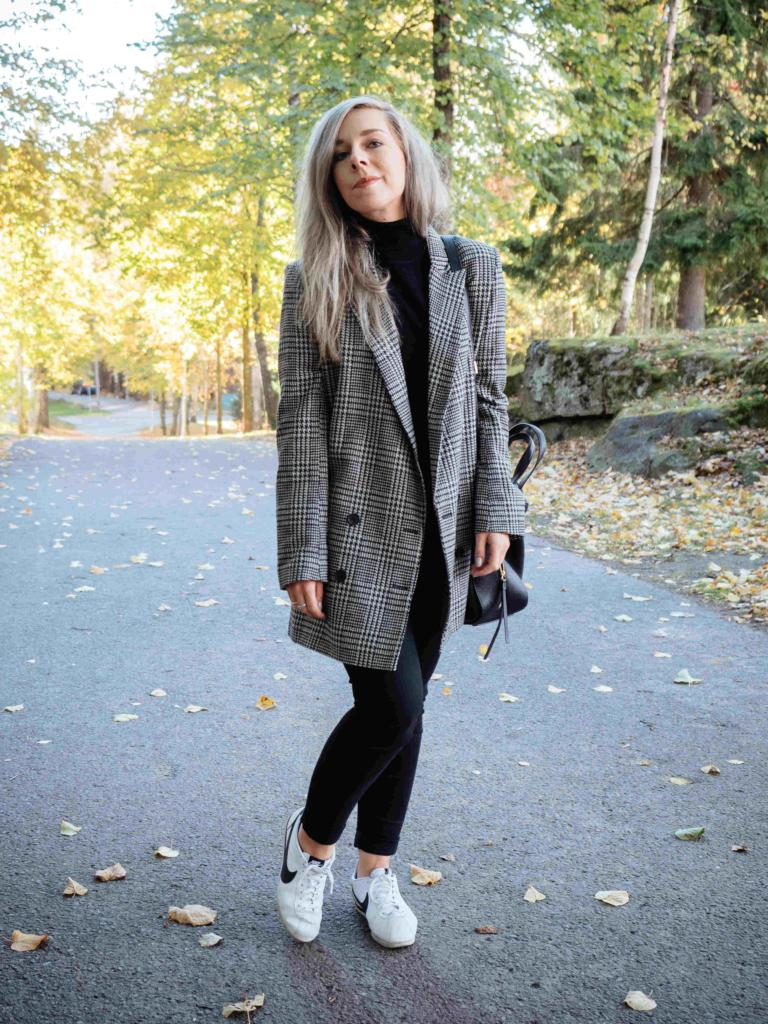

---

Styling a gray jacket can be both versatile and chic! Here are some ideas inspired by the images you provided:

### 1. **Casual Chic**
In the first image, the gray jacket is paired with a white button-up shirt and blue jeans. This look is perfect for a casual day out or a relaxed office environment. You can enhance this style by:
- Adding a statement necklace or a pair of bold earrings.
- Wearing ankle boots or loafers for a polished finish.
- Rolling up the sleeves for a more laid-back vibe.

### 2. **Sporty Elegance**
The second image showcases a gray jacket with a black turtleneck, black pants, and white sneakers. This look is great for a casual yet stylish appearance. To elevate this style:
- Swap the sneakers for ankle boots or loafers for a more sophisticated look.
- Add a crossbody bag or a structured handbag.
- Incorporate a scarf or a beanie for colder weather.

### 3. **Office Ready**
For a more professional setting, you can style the gray jacket with:
- A pencil skirt or tailored trousers.
- A silk blouse or a fitted top.
- Classic pumps or heeled loafers.
- Minimalist jewelry and a structured tote bag.

### 4. **Weekend Vibes**
For a relaxed weekend look:
- Pair the gray jacket with a graphic tee and distressed jeans.
- Opt for comfortable sneakers or slip-on shoes.
- Add a baseball cap or a beanie for a casual touch.

### 5. **Layered Look**
For colder days, layer the gray jacket with:
- A cozy sweater or a hoodie underneath.
- A long scarf and a beanie.
- Skinny jeans or leggings and knee-high boots.

### 6. **Monochrome Magic**
Create a monochrome look by pairing the gray jacket with different shades of gray:
- Light gray or charcoal gray pants.
- A gray turtleneck or a sweater.
- Gray ankle boots or loafers.
- Silver accessories to complement the gray tones.

### 7. **Pop of Color**
Add a pop of color to your outfit:
- A bright-colored top or blouse underneath the gray jacket.
- Colorful accessories like a scarf, handbag, or shoes.
- Bold lipstick or nail polish to add a fun element.

These ideas should help you make the most out of your gray jacket, whether you're aiming for a casual, professional, or trendy look!

In [ ]:
# Prompt the user to input a clothing item they are interested in
display(Markdown("## Stylist Assistant is ready!"))
display(Markdown("What would you like to style today?"))

query = input("\n")

# Running Retrieval and Generation
results = query_db(query, results=2)
prompt_input = format_prompt_inputs(results, query)
response = vision_chain.invoke(prompt_input)

display(Markdown("---"))
# Showing Retrieved Pictures
display(Markdown("**Example Picture 1:**"))
display(Image(filename=results['uris'][0][0], width=300))
display(Markdown("**Example Picture 2:**"))
display(Image(filename=results['uris'][0][1], width=300))

display(Markdown("---"))
# Printing LLM Response
display(Markdown(response))